In [40]:
#source: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [41]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt
import create_simdata
import functions
from tqdm import tqdm

**LSTM data preparation**

We need to divide the data into input X and output y. 

Since we assume univariate data, this can be achieved by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as output.
We shift the series by some specified lag and then concatenate them into the dataframe.

In [42]:
#transforming time series to supervised learning
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    #theoretically can have several lagged values
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

The dataset is not stationary, because the data depend on timing (who could've thought). <br><br>
Standard way of removing a trend is by differencing the data. Observation from time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next. <br><br>
So the trend is removed from the observations using the following function...

In [43]:
def difference(dataset, interval = 1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

...then added back to forecasts later to return the prediction to the original scale.

In [44]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

LSTMs expect data to be within the scale of the activation function.
Since default activation function for LSTMs is *tanh*, we need to scale our values to be between -1 and 1.<br>
*The same min and max values should be used for both train and test sets to ensure the fairness of experiment.*

In [45]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range = (-1,1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

And then we need to invert data back to compare to the ground truth.

In [46]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X]+[value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0,-1]

**LSTM model development**

LSTM is a type of RNN, which can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

LSTM layer expects input to be in a matrix with dimenstions [samples, time steps, features].

*Samples*: independent observations from the domain (rows of data) <br>
*Time steps*: separate time steps of a given variable for a given observation <br>
*Features*: separate measures observed at the time of observation

For this dataset, we can frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.<br>
*maybe will change this later, because training takes long time*

In [47]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    #leaves us with one feature and one vector for predictions
    X, y = train[:,0:-1], train[:,-1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    #X.shape = (#ofsamples, 1 time step, 1 feature)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape = (batch_size, X.shape[1], X.shape[2]), stateful = True))
    #output layer with only one neuron
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", optimizer = "adam")
    #tqdm is just for fancy progress bar
    for i in tqdm(range(nb_epoch)):
        model.fit(X,y,epochs=1, batch_size = batch_size, verbose = 0, shuffle = False)
        model.reset_states()
    return model

Rolling forecast scenario is used (walk-forward model validation).

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

In [48]:
def forecast_lstm(model, batch_size, X):
    #
    X = X.reshape(1,1,len(X))
    yhat = model.predict(X, batch_size = batch_size)
    return yhat[0,0]

In [49]:
functions = [("linear1_abrupt",create_simdata.linear1_abrupt),
             ("linear2_abrupt",create_simdata.linear2_abrupt),
             ("linear3_abrupt",create_simdata.linear3_abrupt),
             ("linear1_inc", create_simdata.linear1_inc),
             ("linear2_inc", create_simdata.linear2_inc),
             ("linear3_inc", create_simdata.linear3_inc),
             ("nonlinear1_abrupt",create_simdata.nonlinear1_abrupt),
             ("nonlinear2_abrupt",create_simdata.nonlinear2_abrupt),
             ("nonlinear3_abrupt",create_simdata.nonlinear3_abrupt),
             ("nonlinear1_inc", create_simdata.nonlinear1_inc),
             ("nonlinear2_inc", create_simdata.nonlinear2_inc),
             ("nonlinear3_inc", create_simdata.nonlinear3_inc)]
#dictionary to store rmse for every dataset
rmse_dict = {}

100%|██████████| 1000/1000 [07:47<00:00,  2.14it/s]


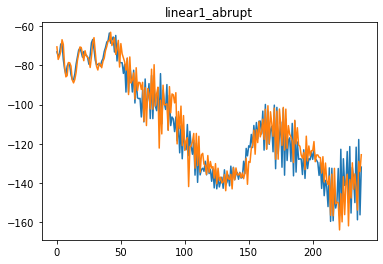

100%|██████████| 1000/1000 [07:43<00:00,  2.16it/s]


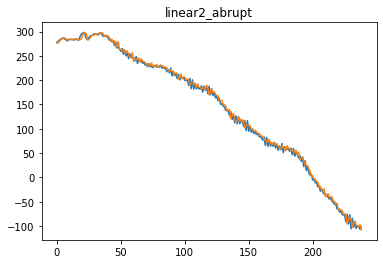

100%|██████████| 1000/1000 [07:48<00:00,  2.13it/s]


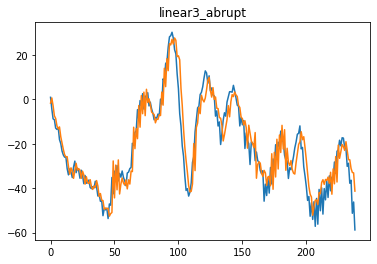

100%|██████████| 1000/1000 [18:42<00:00,  1.12s/it]


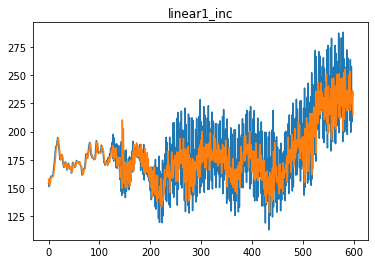

100%|██████████| 1000/1000 [17:32<00:00,  1.05s/it]


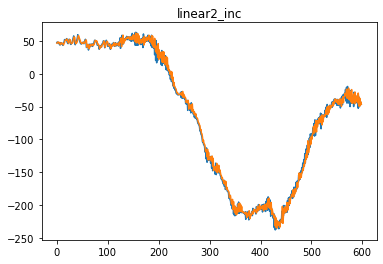

100%|██████████| 1000/1000 [17:54<00:00,  1.07s/it]


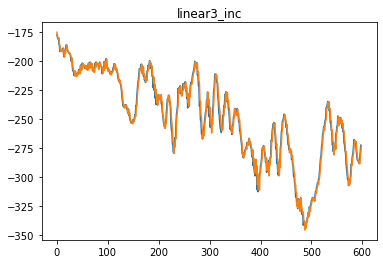

100%|██████████| 1000/1000 [07:45<00:00,  2.15it/s]


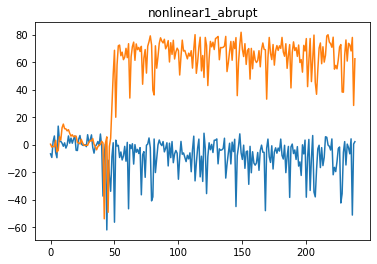

100%|██████████| 1000/1000 [07:37<00:00,  2.18it/s]


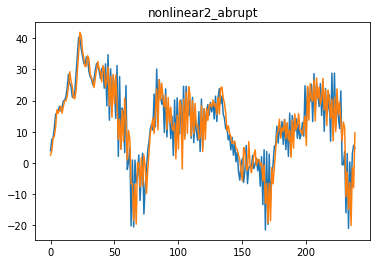

100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s]


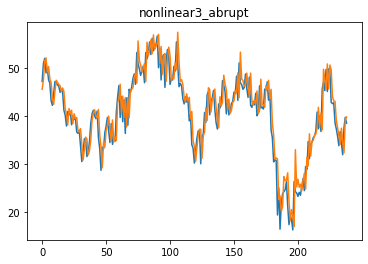

100%|██████████| 1000/1000 [18:04<00:00,  1.08s/it]


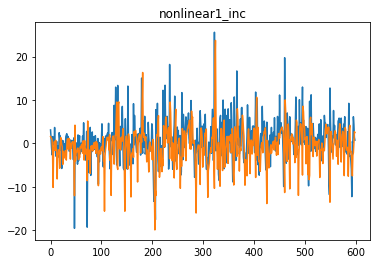

100%|██████████| 1000/1000 [17:52<00:00,  1.07s/it]


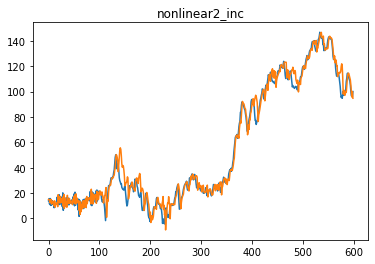

100%|██████████| 1000/1000 [17:58<00:00,  1.08s/it]


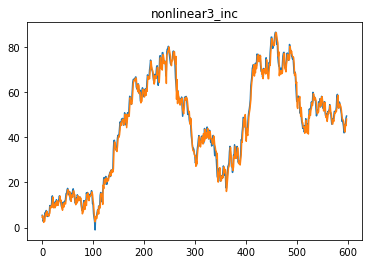

In [50]:
for name, fun in functions:
    series = pd.Series(fun())
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    n = len(series)
    #70%/30% train/test split
    train, test = supervised_values[0:int(n*0.7)], supervised_values[int(n*0.7):]
    scaler, train_scaled, test_scaled = scale(train, test)
    #training on 560 observations for 1000 epochs takes about 8 minutes for abrupt
    #17 minutes for incremental
    lstm_model = fit_lstm(train_scaled, 1, 1000, 4)
    train_reshaped = train_scaled[:,0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size = 1)
    predictions = []
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i,-1]
        yhat = forecast_lstm(lstm_model, 1, X)
        yhat = invert_scale(scaler, X, yhat)
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        predictions.append(yhat)
        expected = raw_values[len(train)+i+1]
    #+1 because the first value is fed to the lstm to make prediction of the second value
    rmse = sqrt(mse(raw_values[int(0.7*n)+1:], predictions))
    rmse_dict[name] = rmse
    plt.plot(raw_values[int(0.7*n)+1:])
    plt.plot(predictions)
    plt.title(name)
    plt.show()

In [52]:
print(rmse_dict)

{'linear1_abrupt': 6.668511579128563, 'linear2_abrupt': 6.52985284605289, 'linear3_abrupt': 7.403192823612805, 'linear1_inc': 29.800521333752958, 'linear2_inc': 5.998137979038862, 'linear3_inc': 5.596696462102889, 'nonlinear1_abrupt': 68.32099960684441, 'nonlinear2_abrupt': 5.548595893956695, 'nonlinear3_abrupt': 3.543154811059639, 'nonlinear1_inc': 6.40490099059484, 'nonlinear2_inc': 6.470255181386809, 'nonlinear3_inc': 2.641739607972042}
